# Pixabay Data Analysis


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

from db_interaction import db

data = db.load_data_into_df()

sns.set(style="whitegrid")

## Linear regression visualizations

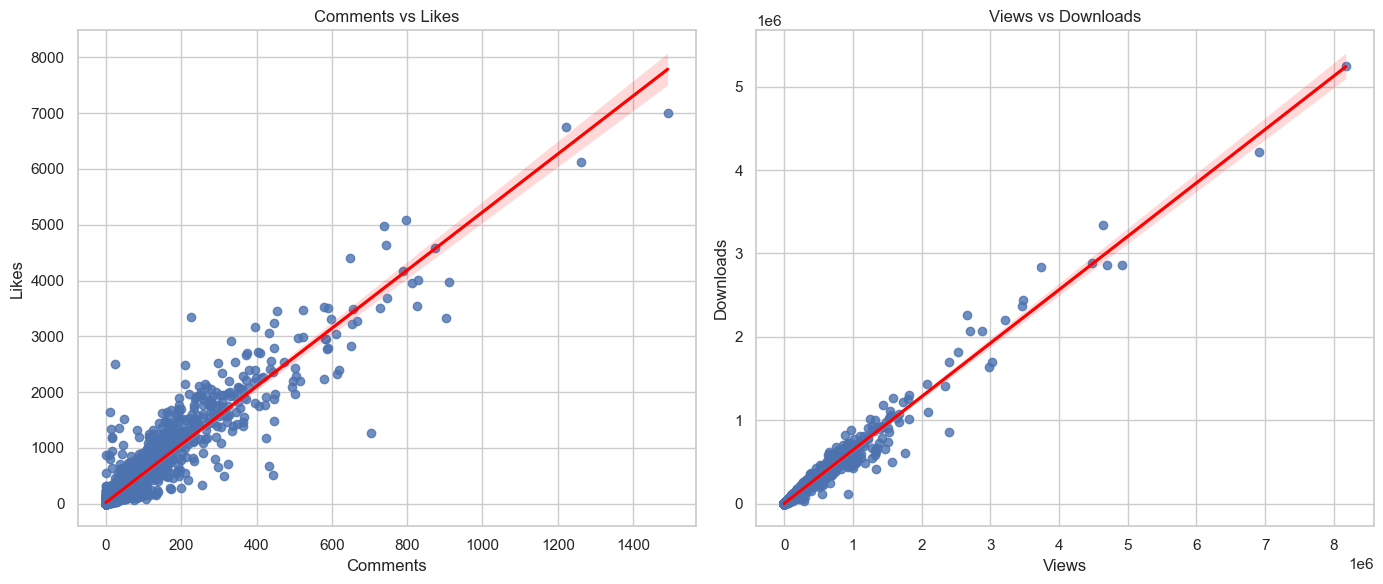

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.regplot(ax=axes[0], x=data['comments'], y=data['likes'], line_kws={"color": "red"}).set(
    title='Comments vs Likes', xlabel='Comments', ylabel='Likes')
sns.regplot(ax=axes[1], x=data['views'], y=data['downloads'], line_kws={"color": "red"}).set(
    title='Views vs Downloads', xlabel='Views', ylabel='Downloads')
plt.tight_layout()
plt.show()

### Comments vs Likes: 
There's a positive relationship between the number of comments and likes an image receives. As comments increase, likes tend to increase as well, suggesting engagement in one form correlates with engagement in another. The visualization highlights points that have different ratios of likes to comments, which may indicate higher contention for some images

### Views vs Downloads: 
There's a positive correlation between views and downloads. Images that are viewed more often also tend to be downloaded more frequently. The ratio of likes to views is more even

## Plot the top 10 tags for likes, downloads and count

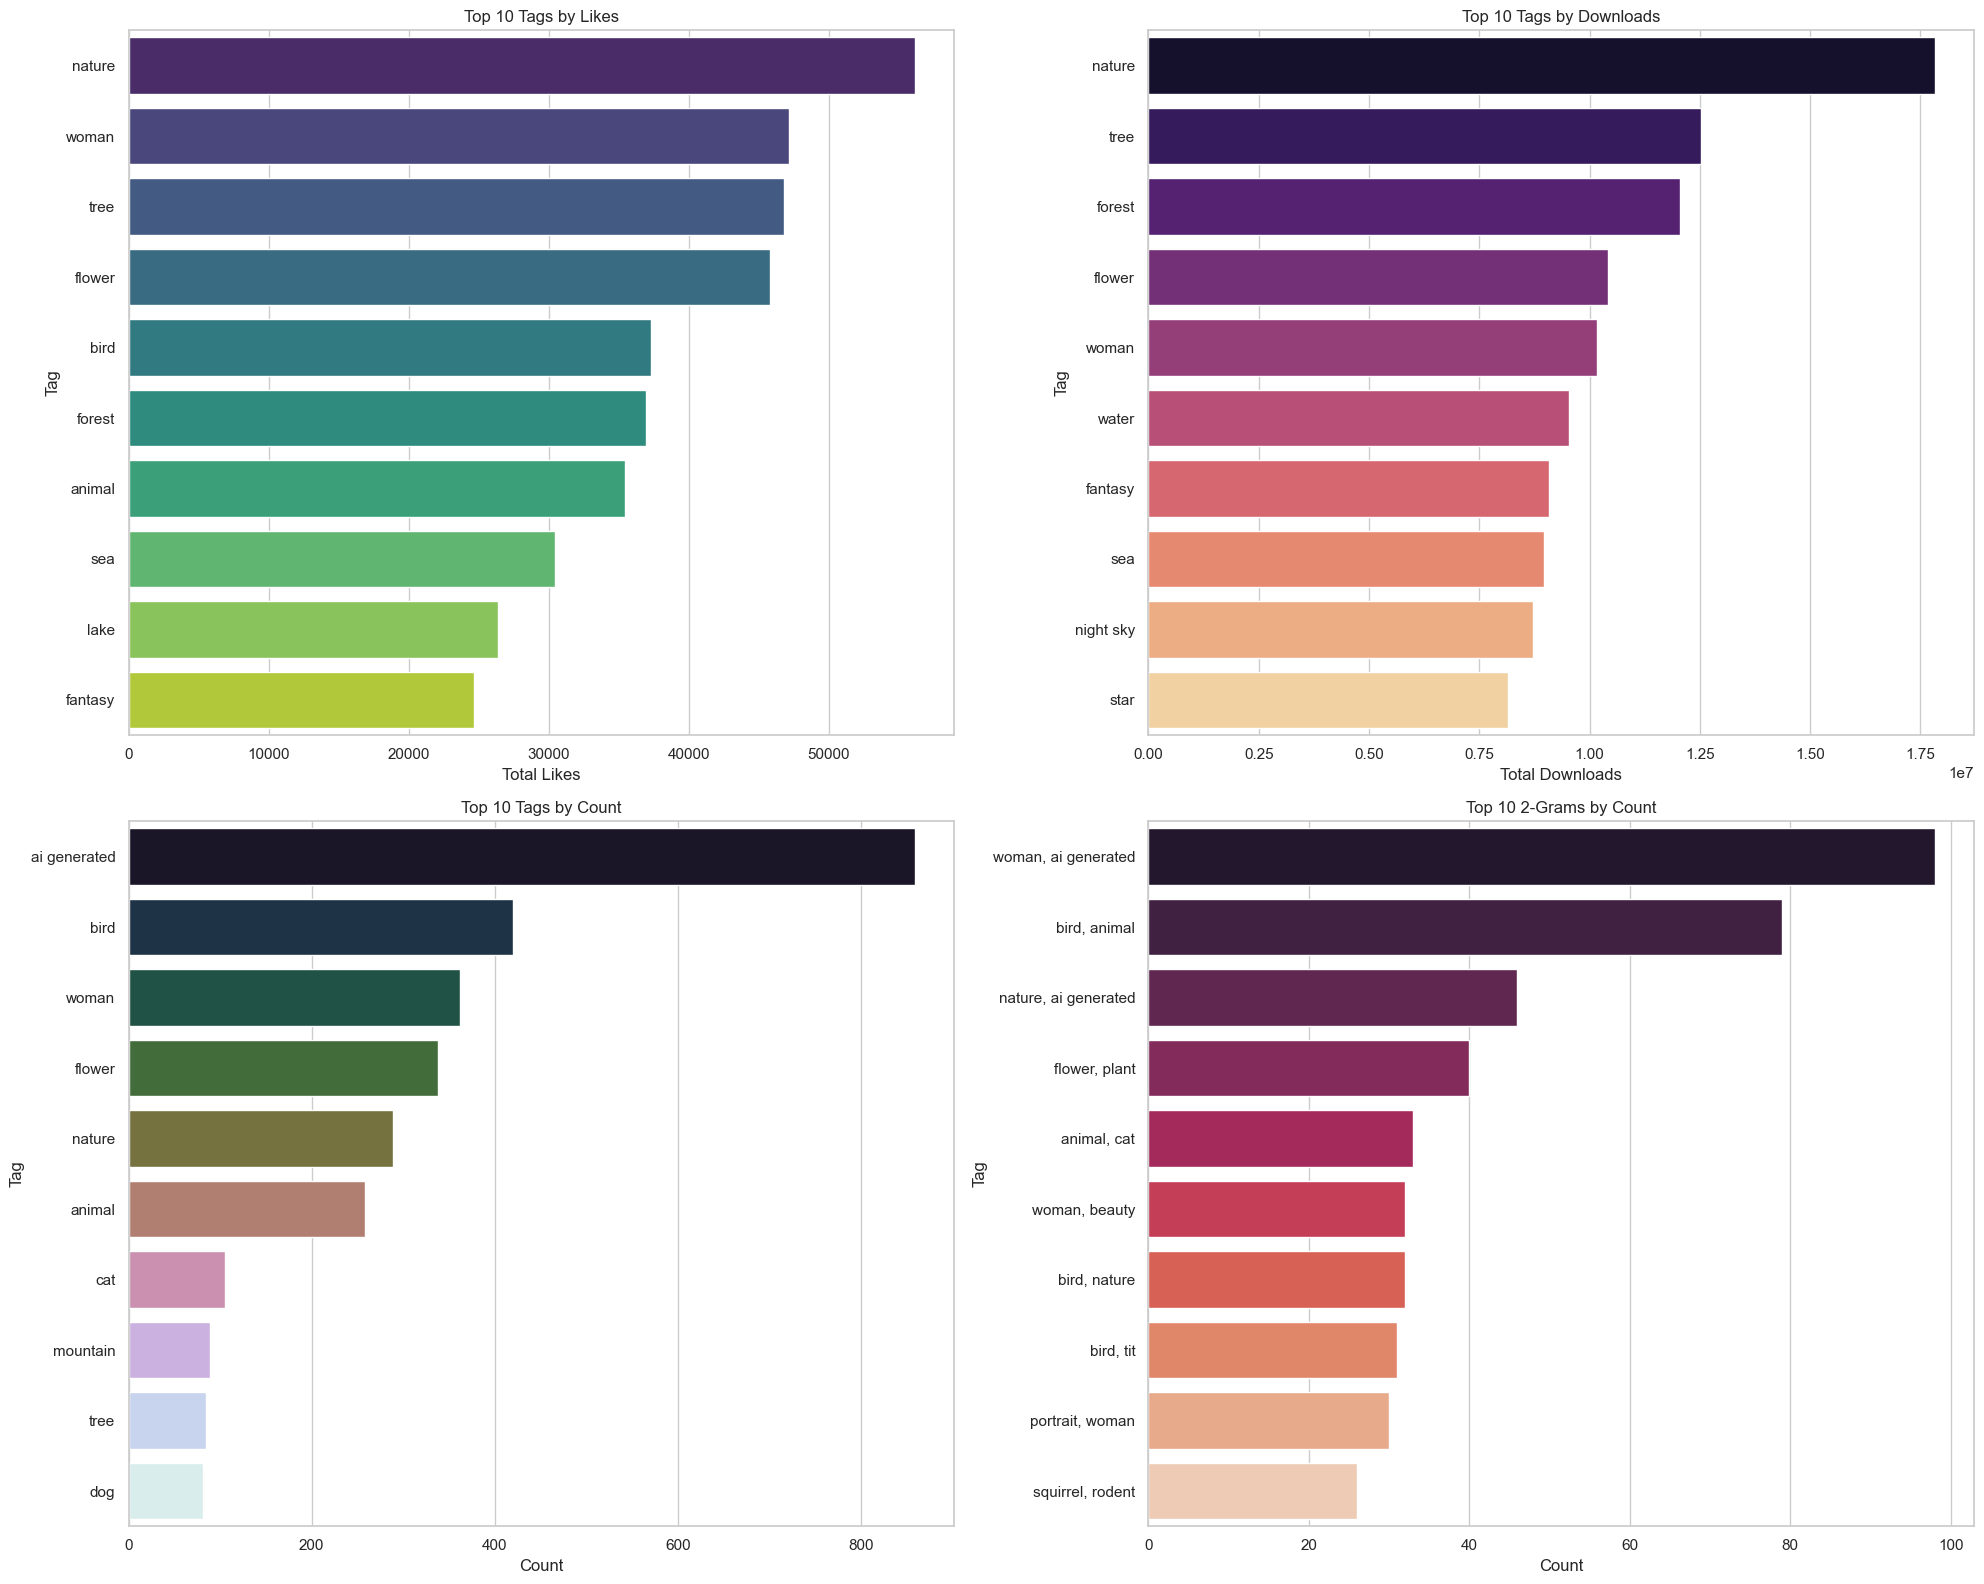

In [4]:
tag_likes = defaultdict(int)
tag_downloads = defaultdict(int)
tag_counts = Counter()
tag_2grams = Counter()

for _, row in data.iterrows():

    tags = row['tags'].split(', ')

    for i in range(len(tags)):

        tag_likes[tags[i]] += row['likes']
        tag_downloads[tags[i]] += row['downloads']
        tag_counts[tags[i]] += 1
        if i < len(tags) - 1:
            tag_2grams[(tags[i], tags[i+1])] += 1

tags_likes_df = pd.DataFrame(list(tag_likes.items()), columns=['Tag', 'Total Likes']).sort_values(by='Total Likes', ascending=False)
tags_downloads_df = pd.DataFrame(list(tag_downloads.items()), columns=['Tag', 'Total Downloads']).sort_values(by='Total Downloads', ascending=False)
tags_counts_df = pd.DataFrame(tag_counts.most_common(), columns=['Tag', 'Count']).head(10)
tags_2grams_df = pd.DataFrame(tag_2grams.most_common(), columns=['Tag', 'Count']).head(10)

tags_2grams_df['Tag'] = tags_2grams_df['Tag'].apply(lambda x: ', '.join(x))

likes_palette = sns.color_palette("viridis", 10)
downloads_palette = sns.color_palette("magma", 10)
count_palette = sns.color_palette("cubehelix", 10)
ngrams_palette = sns.color_palette("rocket", 10)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
sns.barplot(ax=axes[0, 0], x='Total Likes', y='Tag', data=tags_likes_df.head(10), palette=likes_palette, hue='Tag', dodge=False)
sns.barplot(ax=axes[0, 1], x='Total Downloads', y='Tag', data=tags_downloads_df.head(10), palette=downloads_palette, hue='Tag', dodge=False)
sns.barplot(ax=axes[1, 0], x='Count', y='Tag', data=tags_counts_df, palette=count_palette, hue='Tag', dodge=False)
sns.barplot(ax=axes[1, 1], x='Count', y='Tag', data=tags_2grams_df, palette=ngrams_palette, hue='Tag', dodge=False)

axes[0, 0].set_title('Top 10 Tags by Likes')
axes[0, 1].set_title('Top 10 Tags by Downloads')
axes[1, 0].set_title('Top 10 Tags by Count')
axes[1, 1].set_title('Top 10 2-Grams by Count')

plt.tight_layout()
plt.show()

### Top Tags by Likes: 
Images with the tag "nature" get the most likes. Most of the tags with the most likes are related to nature in one way or another, mostly flora, or general, such as "nature". However, there are two exceptions: "woman" and "fantasy"
### Top Tags by Downloads: 
The distribution of tags by the number of downloads is similar to the distribution by the number of likes. Differences: the tag "woman" moved from 2nd to 5th position. There are no tags related to animals in this distribution, instead "star" and "night sky" have been added, which shows people's interest in tags related to stars
### Top Tags by Count:
It is worth noting that the number of top tags is not completely evenly distributed. The difference between the first most common tag and the second is about 2 times, as is the difference between the 6th and 7th. Most of the tags that are on most of the images, as in the previous distributions, are related to nature, but if the previous visualizations were dominated by tags related to non-living nature, here we see a large number of tags related to animals. It is worth noting the very large number of images with the tag "ai generated"
### Top Tag-pairs:
Top tag-pairs correlate with previous quantitative visualization. We can say that paired tags specify with which specific tags the most popular ones are used ("bird, animal", "animal, cat", "plant, flower").The most frequent are pairs using "ai generated", "woman" and nature-related tags



## Distribution of likes

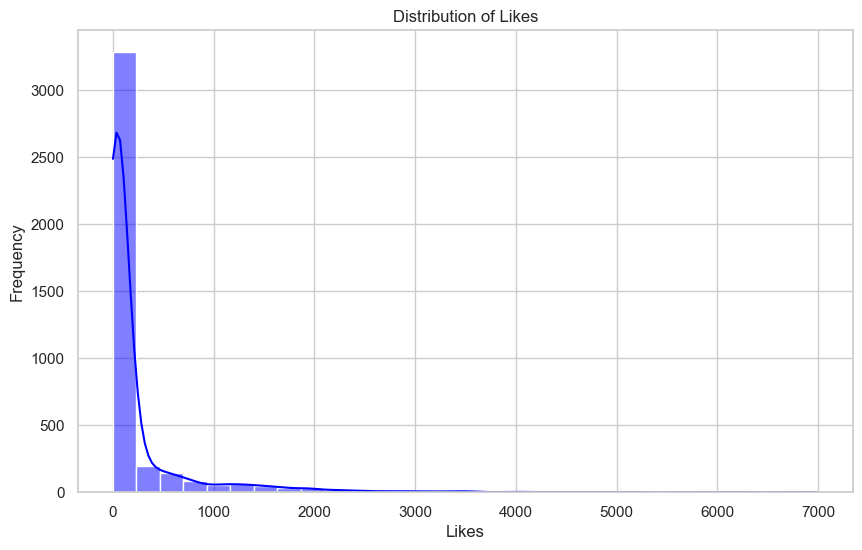

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data['likes'], bins=30, kde=True, color='blue', ax=ax)
ax.set_title('Distribution of Likes')
ax.set_xlabel('Likes')
ax.set_ylabel('Frequency')
plt.show()

### Skewed Distribution: 
The data is heavily right-skewed. It means that most images receive a relatively low number of likes, while a few images receive a very high number.
### Presence of Outliers: 
The long tail to the right suggests there are outliers with an exceptionally high number of likes compared to the majority.

## Analysis per user

In [10]:
user_stats = data.groupby('user').agg(
    total_images=pd.NamedAgg(column='pageURL', aggfunc='count'), 
    total_likes=pd.NamedAgg(column='likes', aggfunc='sum'),
    total_downloads=pd.NamedAgg(column='downloads', aggfunc='sum'),
    average_views_mlns=pd.NamedAgg(column='views', aggfunc=lambda x: round(x.mean() / 1000000, 3)),  
    average_comments=pd.NamedAgg(column='comments', aggfunc=lambda x: round(x.mean(), 2))
).reset_index()
user_stats_sorted = user_stats.sort_values(by='total_downloads', ascending=False).head(10)
def highlight_max(s, props='background-color:yellow;'):
    """Highlight the maximum in a Series yellow."""
    return [props if v == s.max() else '' for v in s]

styled_table = user_stats_sorted.style\
    .format({
        'total_images': "{:,}",
        'total_likes': "{:,}",
        'total_downloads': "{:,}",
        'average_views_mlns': "{:.3f}",
        'average_comments': "{:.2f}"
    })\
    .apply(highlight_max, subset=['total_images', 'total_likes', 'total_downloads', 'average_views_mlns', 'average_comments'])\
    .set_table_styles([{
        'selector': 'th',
        'props': [
            ('font-size', '12pt'),
            ('text-align', 'center'),
            ('font-weight', 'bold'),
            ('color', '#6d6d6d'),
            ('background-color', '#f7f7f9')
        ]
    }, {
        'selector': 'td',
        'props': [
            ('text-align', 'center'),
            ('font-size', '11pt')
        ]
    }])\
    .set_properties(**{'border': '1.5px solid black', 'padding': '8px'})
styled_table

,user,total_images,total_likes,total_downloads,average_views_mlns,average_comments
213,FelixMittermeier,9,"18,911","10,648,545",1.733,338.11
474,Pexels,25,"25,437","10,023,109",0.584,166.52
820,jplenio,32,"15,836","7,887,471",0.367,70.56
606,Valiphotos,2,"13,123","5,723,987",4.811,1377.00
446,NoName_13,21,"18,047","5,530,815",0.363,113.81
3,12019,10,"17,339","4,882,046",0.734,213.80
109,Bessi,8,"18,585","4,586,134",1.085,432.88
172,Darkmoon_Art,11,"10,348","4,439,660",0.499,167.73
170,Daria-Yakovleva,4,"6,343","3,653,225",1.292,257.75
490,PublicDomainPictures,7,"11,470","3,558,136",0.876,325.43


### High Downloads: 
Users like Pexels, jplenio, and FelixMittermeier have exceptionally high download numbers. This suggests that their content is not only popular but also highly utilized, which could indicate high-quality or highly relevant material for users.
### Usage Implications: 
High downloads relative to views (and even likes) could indicate that the images are useful for practical purposes, such as in presentations, blogs, or other media, where downloading is necessary to use the content.
### Valiphotos' Outlier Performance: 
With an average of 4.809 million views per image and extremely high average comments, this user's content likely resonates strongly or is very eye-catching, drawing both passive viewers and active interactors.
### Content Virality: 
High average views, especially millions per image, suggest potential virality or broad appeal. Daria-Yakovleva and Bessi show high views but the total number of likes and downloads is less compared to neighboring users in the table, indicating their content might be striking or widely shared across platforms.
### Engagement versus Volume: 
Users with the most images don't always have the most likes, views, or downloads. For most users with a large number of images, these indicators are not at a high level. Most users with high rates of likes, views and downloads have around 10 images in total
### Interactive Content: 
High average comments, like those for Valiphotos, suggest that the content prompts viewers to interact, possibly due to the evocative nature of the images or topics that spark discussion.